In [1]:
# need to install ipympl and restart jupyter notebook
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install pandas

In [2]:
from utils import yamlread

import conf_mgt
from test import sample_now, main, build_conf
import lpips

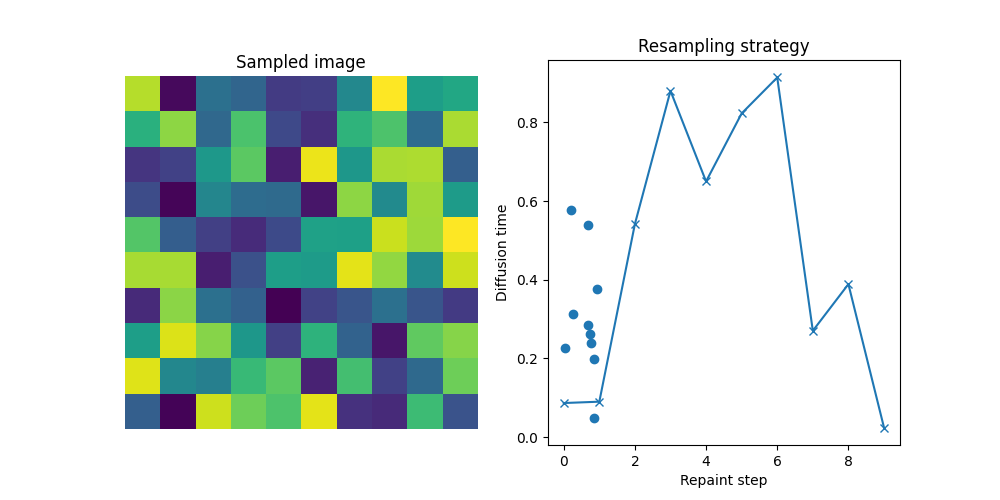

In [4]:
conf_arg = conf_mgt.conf_base.Default_Conf()
conf_arg.update(yamlread('confs/face_example.yml'))
conf_arg['reload'] = False
conf_arg['save_model'] = 'save_jn.pkl'
conf_arg['save_idx'] = [14]
conf_arg['stop_it'] = [14]
p, ani = main(conf_arg)

In [4]:
p.terminate()
ani.event_source.stop()

In [ ]:
# go to iteration 40, and then try different seeds
# to see where they bring

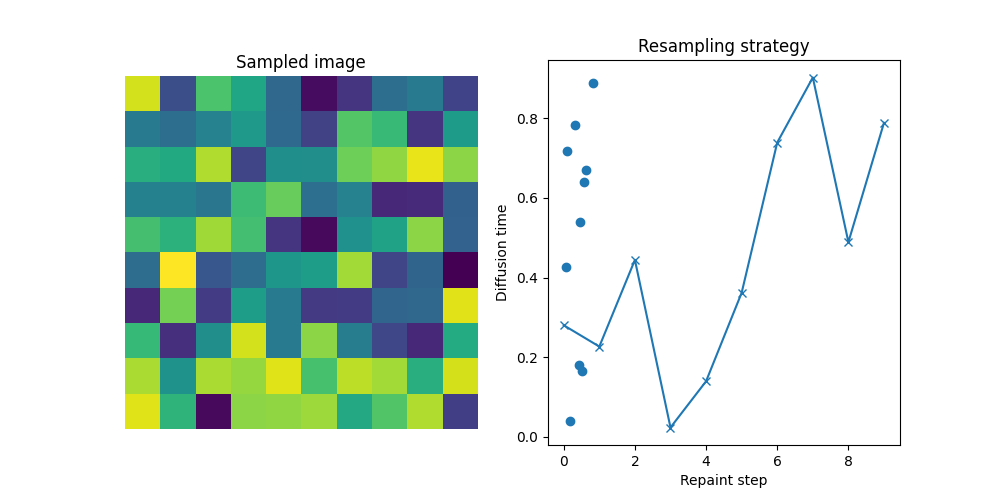

In [15]:
conf_arg = conf_mgt.conf_base.Default_Conf()
conf_arg.update(yamlread('confs/face_example.yml'))
conf_arg['reload'] = True
conf_arg['save_model'] = 'save_jn.pkl'
conf_arg['save_idx'] = []
conf_arg['stop_it'] = []
p, ani = main(conf_arg)

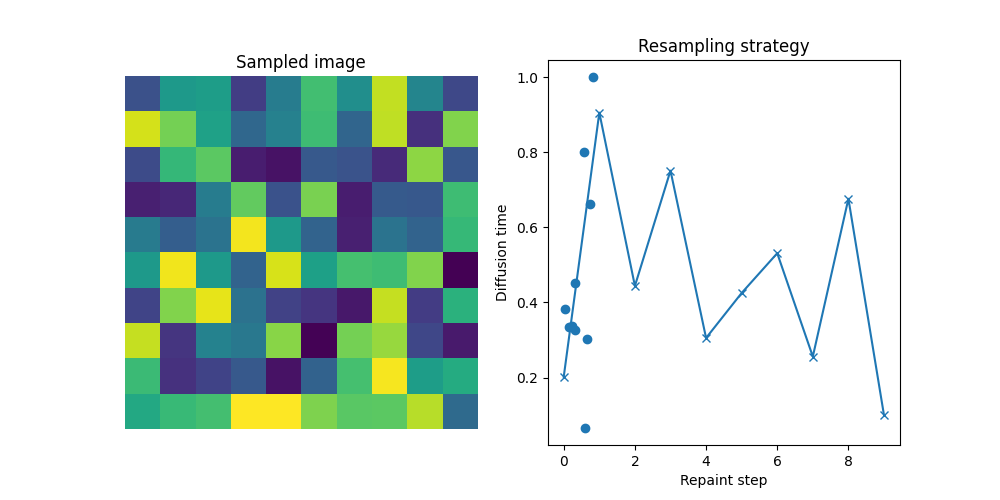

In [16]:
conf_arg = conf_mgt.conf_base.Default_Conf()
conf_arg.update(yamlread('confs/face_example.yml'))
conf_arg['seed'] = 1
conf_arg['reload'] = True
conf_arg['save_model'] = 'save_jn.pkl'
conf_arg['save_idx'] = []
conf_arg['stop_it'] = []
p, ani = main(conf_arg)

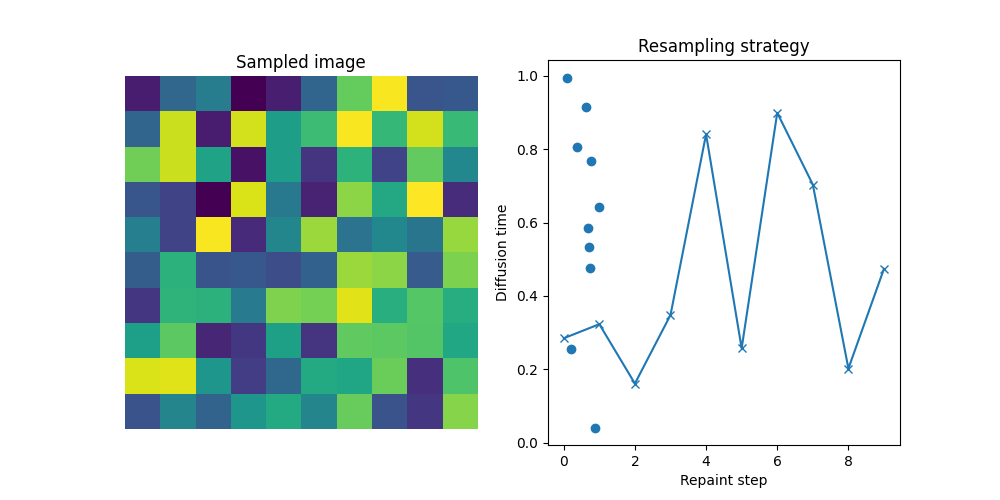

In [18]:
conf_arg = conf_mgt.conf_base.Default_Conf()
conf_arg.update(yamlread('confs/face_example.yml'))
conf_arg['seed'] = 1
conf_arg['reload'] = True
conf_arg['save_model'] = 'save_jn.pkl'
conf_arg['save_idx'] = []
conf_arg['stop_it'] = []
conf_arg['manual_times'] = [5,4,3,4,5,4,3,2,1,0,-1]
p, ani = main(conf_arg)

### Resizing images

In [8]:
import cv2
types = 'gt_keep_masks/genhalf'
types2 = 'gt_keep_masks/genhalf3'
# types = 'gts/inet256'
for i in range(8):
    img = cv2.imread(f'data/datasets/{types}/00000{i}.png', cv2.IMREAD_UNCHANGED)
    
    print('Original Dimensions : ',img.shape)
    
    width = int(img.shape[1] * 1 / 4)
    height = int(img.shape[0] * 1 / 4)
    dim = (width, height)
    
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    print('Resized Dimensions : ',resized.shape)

    cv2.imwrite(f'data/datasets/{types2}/00000{i}.png', resized)
    
    # cv2.imshow("Resized image", resized)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (64, 64, 3)
Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (64, 64, 3)
Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (64, 64, 3)
Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (64, 64, 3)
Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (64, 64, 3)
Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (64, 64, 3)
Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (64, 64, 3)
Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (64, 64, 3)


### Comparing ImageNet 64 with ImageNet 256: time and performance

conf_arg = conf_mgt.conf_base.Default_Conf()
conf_arg.update(yamlread('confs/face_example.yml'))
conf_arg['reload'] = False
conf_arg['save_model'] = 'save_jn.pkl'
conf_arg['save_idx'] = [14]
conf_arg['stop_it'] = [14]
p, ani = main(conf_arg)

In [1]:
import pandas

ModuleNotFoundError: No module named 'pandas'

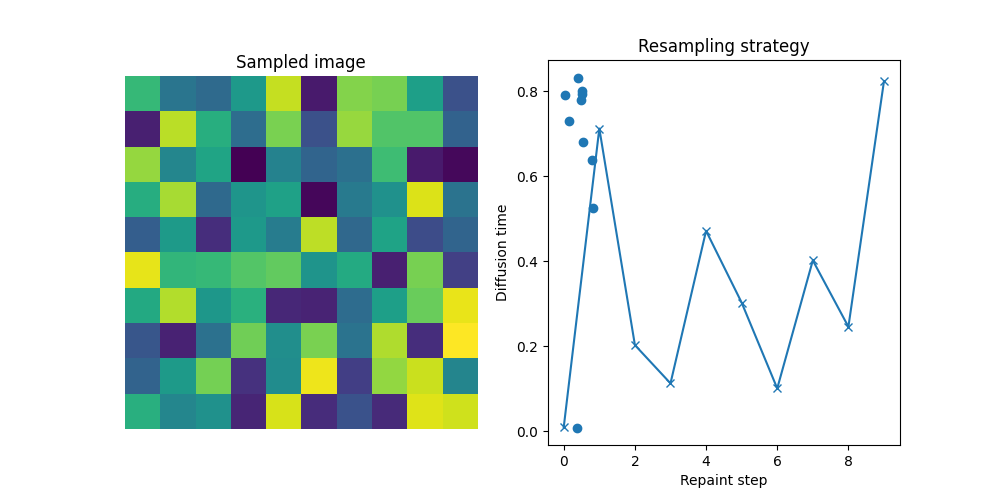

In [14]:
conf = build_conf("image_size_inet", "inet64", 10, 5)
p, ani = main(conf)

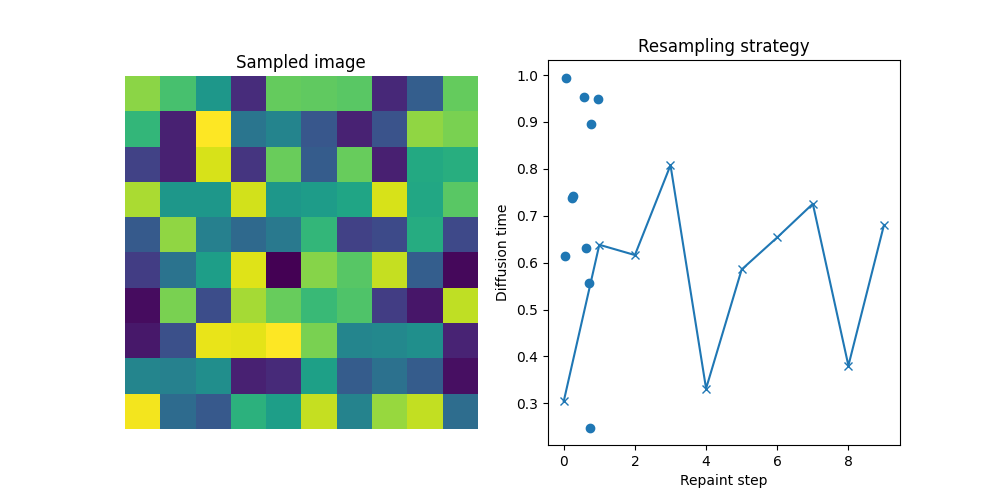

In [6]:
conf = build_conf("image_size_inet", "inet256", 1, 5)
p, ani = main(conf)

# Methods

Paper inspired from [Open AI guided diffusion](https://arxiv.org/pdf/2105.05233.pdf).

### Diffusion model



### Metrics

#### User study

#### LPIPS / FID

## Configuration

In [ ]:
conf_path = 'confs/face_example.yml'
conf_arg = conf_mgt.conf_base.Default_Conf()
conf_arg.update(yamlread(conf_path))

## Resampling schedule

Implement resampling and as a function of the size of the hidden mask

In [ ]:
# start resampling from middle and merge data lately

## Diffusion process step by step

Only 25 passes with classifierg guidance
not working to scheduler 0, 10, ... 250
nor less than 250

## Classifier

Ideas to optimize

- u8 weights
- smaller resolution 64x64

In [ ]:
!pip install lpips

In [12]:
import lpips
import torch as th
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores

# read png image
file_img0 = 'log/face_example/inpainted/000000.png'
file_img1 = 'log/face_example/inpainted/000000 copy.png'
file_img1 = 'log/face_example/inpainted/000000 copy 2.png'
file_img1 = 'log/face_example/gt/000000.png'
img0 = cv2.imread(file_img0, cv2.IMREAD_UNCHANGED)
img1 = cv2.imread(file_img1, cv2.IMREAD_UNCHANGED)

img0 = th.from_numpy(img0).permute(2, 0, 1).unsqueeze(0).float() / 255
img1 = th.from_numpy(img1).permute(2, 0, 1).unsqueeze(0).float() / 255

d = loss_fn_alex(img0, img1)
print(d)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\PolletStars\Anaconda3\envs\repaint\lib\site-packages\lpips\weights\v0.1\alex.pth
tensor([[[[0.1664]]]], grad_fn=<AddBackward0>)


## Going further

- diffusion model inversion (bigprior) ? DDIM Song and al ?

https://www.youtube.com/watch?v=lvv4N2nf-HU openAI Glide